In [1]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
interactive_figures = True
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 5)

from util import er
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers, callbacks
import tensorflow_probability as tfp
from scipy import stats
from sklearn import metrics

# Configuration
data_folder = '/app/data'

# Load data
data = er.load_data(data_folder)

# Hourly code counts
codes = pd.get_dummies(data['Code'])
codes.set_index(data['Triage'], inplace=True)
codes.columns = codes.columns.to_list()
codes_b = codes.resample('H').sum()

# Compute totals
cols = ['white', 'green', 'yellow', 'red']
codes_b['total'] = codes_b[cols].sum(axis=1)

# Arrival Prediction

## Arrival Prediction

**We can now frame our arrival prediction problem**

We want to predict the number of arrivals in the next interval

* We will focus on predicting the _total number of arrivals_
* The same models can be applied to any of the individual counts

**Technically, this is a regression problem**

* ...Which does _not_ mean that an MSE is the best choice
* It makes more sense to _check the target distribution_ first

**Main issue: our regressor will learn a conditional probability distribution**

* ...So, that's the kind of distribution that we should check, in principle
* It is a difficult task, since we do not know yet which input we are goig to use

However, we already know that _some features_ are likely to be useful

## Analyzing the Conditional Arrival Distribution

**...In particuar, we know that the hour of the day is a good predictor**

Let's check the (conditional) distribution for 6am:

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
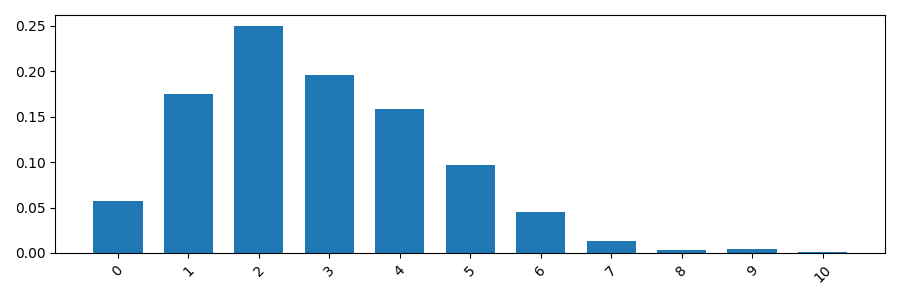

In [9]:
tmp = codes_b[codes_b.index.hour == 6]['total']
tmpv = tmp.value_counts(sort=False, normalize=True).sort_index()
er.plot_bars(tmpv, figsize=figsize)

* This is _not_ a normal distribution

## Poisson Distribution

**When we need to count occurrencies over time...**

It's almost always worth checking the _Poisson distribution_, which models:

* The number of occurrences of a certain event in a given interval
* ...Assuming that these events are _independent_
* ...And they occur at a _constant_ rate

**In our case:**

* The independence assumption is reasonable (arrivals do not affect each other)
* The constant rate is true _for the conditional probability_
* ...Assuming that our predictor is _good enough_

Intuitively: the predictor will estimate the constant rate

## Poisson Distribution

**The Poisson distribution is defined by a single parameter $\lambda$**

$\lambda$ is the rate of occurrence of the events

* The distribution has a _discrete support_
* The Probability Mass Function is:
$$
p(k, \lambda) = \frac{\lambda^k e^{-\lambda}}{k!}
$$
* Both the _mean_ and the _standard deviation_ have the same value (i.e. $\lambda$)
* The distribution skewness is $\lambda^{-\frac{1}{2}}$
  - For low $\lambda$ values, there is a significant positive skew (to the left)
  - The distribution becomes less skewed for large $\lambda$

## Fitted Poisson Distribution

**Let's try to fit a Poisson distribution over our target**

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
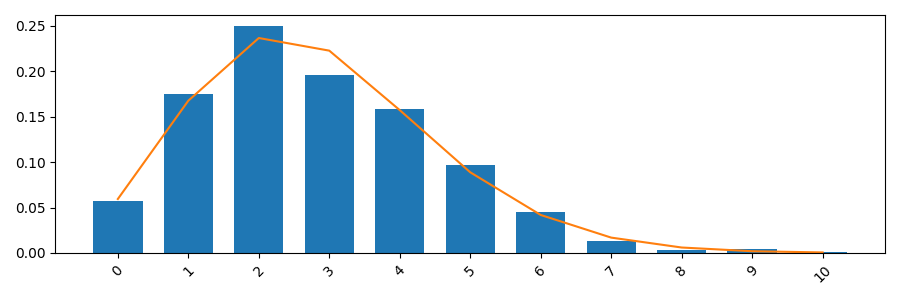

In [11]:
mu = tmp.mean()
dist = stats.poisson(mu)
x = np.arange(tmp.min(), tmp.max()+1)
er.plot_bars(tmpv, figsize=figsize, series=pd.Series(index=x, data=dist.pmf(x)))

It's a very good match!

## Fitted Poisson Distribution

**Let's try for 8AM (closer to the peak)**

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
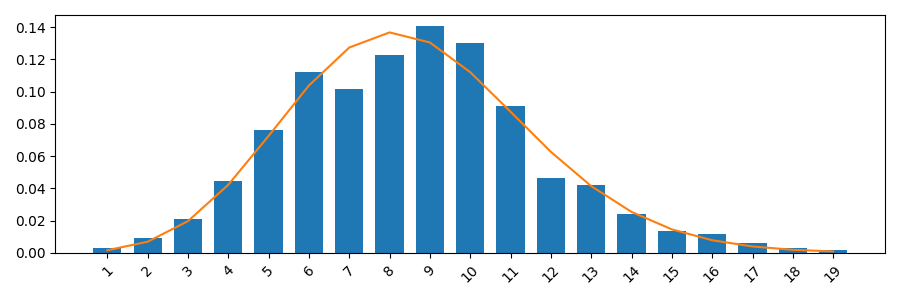

In [12]:
tmp = codes_b[codes_b.index.hour == 8]['total']
tmpv = tmp.value_counts(sort=False, normalize=True).sort_index()
mu = tmp.mean()
dist = stats.poisson(mu)
x = np.arange(tmp.min(), tmp.max()+1)
er.plot_bars(tmpv, figsize=figsize, series=pd.Series(index=x, data=dist.pmf(x)))

## Fitted Poisson Distribution

**...And finally for the peak itself**

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
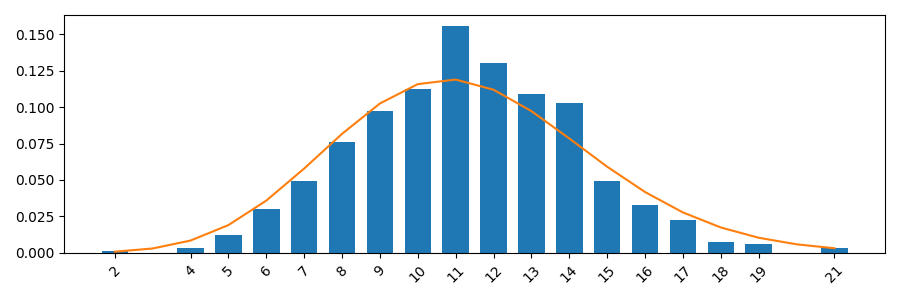

In [13]:
tmp = codes_b[codes_b.index.hour == 11]['total']
tmpv = tmp.value_counts(sort=False, normalize=True).sort_index()
mu = tmp.mean()
dist = stats.poisson(mu)
x = np.arange(tmp.min(), tmp.max()+1)
er.plot_bars(tmpv, figsize=figsize, series=pd.Series(index=x, data=dist.pmf(x)))

# Table Model

## Rate Table

**We know that:**

* A Poisson distribution is a good fit for our target...
* ...But the rate depends (at least) on the hour of the day

**The simplest way to take this into account is using a _lookup table_**

* The table will contain average arrival values for each hour of the day
* ...But first, we need to separate the training and test data

In [14]:
sep = '2019-01-01'
tr_data = codes_b[codes_b.index < sep]
ts_data = codes_b[codes_b.index >= sep]

## Rate Table

**We can then build our "rate table"**

In [16]:
rate_table = tr_data.groupby(tr_data.index.hour).mean()
rate_table.head()

,green,red,white,yellow,total
Triage,,,,,
0,2.265753,0.219178,0.367123,1.054795,3.906849
1,1.915068,0.213699,0.331507,0.860274,3.320548
2,1.734247,0.202740,0.287671,0.780822,3.005479
3,1.515068,0.153425,0.232877,0.687671,2.589041
4,1.334247,0.134247,0.197260,0.717808,2.383562


* We are computing (average) rates for all the codes
* This will enable changing focus to a different target, if we so wish

## Predictions

**We can not obtain the predictions**

* We need to associate each example withe correct rates
* The rates themselves are then the predictions

In [18]:
def preds_from_rate_table(data, rate_table):
    tmp = data.copy()
    tmp['hour'] = data.index.hour
    tmp = tmp.join(rate_table, on='hour', lsuffix='_orig')
    return tmp[rate_table.columns]

tr_preds = preds_from_rate_table(tr_data, rate_table)
ts_preds = preds_from_rate_table(ts_data, rate_table)

* We use a `join` operation to associate examples and rates

## Evaluation

**We can now evaluate the predictions. First for the _training set:_**

R2: 0.5940116186135868
MAE: 1.945866016138112


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
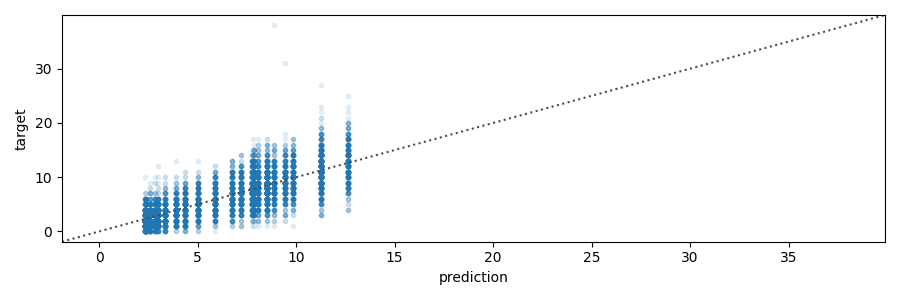

In [19]:
slabel = 'total'
er.plot_pred_scatter(tr_preds[slabel], tr_data[slabel], figsize=figsize)
print(f'R2: {metrics.r2_score(tr_data[slabel], tr_preds[slabel])}')
print(f'MAE: {metrics.mean_absolute_error(tr_data[slabel], tr_preds[slabel])}')

## Evaluation

**...And then for the test set:**

R2: 0.5878063024665628
MAE: 1.9621410117760154


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
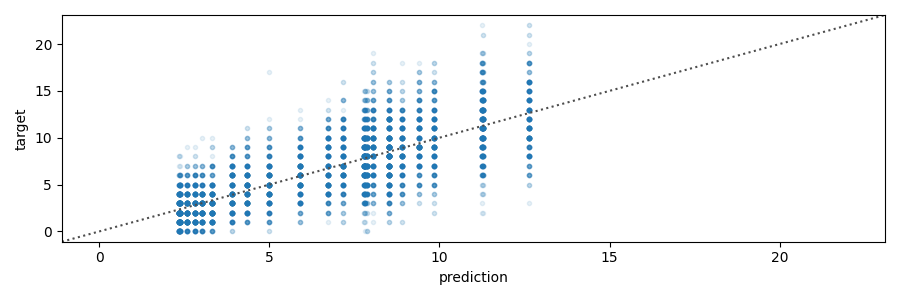

In [20]:
er.plot_pred_scatter(ts_preds['total'], ts_data['total'], figsize=figsize)
print(f'R2: {metrics.r2_score(ts_data[slabel], ts_preds[slabel])}')
print(f'MAE: {metrics.mean_absolute_error(ts_data[slabel], ts_preds[slabel])}')

These results will be our baseline

# Probabilistic Neural Model

## Probabilistic Neural Model

**We will now try to learn a hybrid probabilistic-neural model**

Using a neural network makes adding inputs easier

* We know that there is a slight decreasing trend along week days
* ...So let's try adding the week day as a numerical input

In [29]:
tr_data_in = keras.utils.to_categorical(tr_data.index.hour)
tr_data_in = np.hstack((tr_data_in, (tr_data.index.weekday/7).values.reshape(-1,1) ))

ts_data_in = keras.utils.to_categorical(ts_data.index.hour.values)
ts_data_in = np.hstack((ts_data_in, (ts_data.index.weekday/7).values.reshape(-1,1)))

* We use a categorical encoding for the day hour, due to its non-linear effect
* ...But it is (mostly) fine to use the week day as number, due to its linear effect

## The Architecture

**First we define our architecture**

In [30]:
def build_probabilistic_regressor(input_shape, hidden):
    model_in = keras.Input(shape=input_shape, dtype='float32')
    x = model_in
    for h in hidden:
        x = layers.Dense(h, activation='relu')(x)
    log_rate = layers.Dense(1, activation='linear')(x)
    lf = lambda t: tfp.distributions.Poisson(log_rate=t, force_probs_to_zero_outside_support=False)
    model_out = tfp.layers.DistributionLambda(lf)(log_rate)
    model = keras.Model(model_in, model_out)
    return model

nn2 = build_probabilistic_regressor(tr_data_in.shape[1], hidden=[32])

Instructions for updating:
The `interpolate_nondiscrete` flag is deprecated; instead use `force_probs_to_zero_outside_support` (with the opposite sense).
Instructions for updating:
The `interpolate_nondiscrete` property is deprecated; instead use `force_probs_to_zero_outside_support` (with the opposite sense).


* We use an MLP, plus a `DistributionLambda` layer for the Poisson distribution
* We will try with a shallow network

## The Architecture

**We can also plot the architecture**

In [31]:
nn2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 25)]              0         
_________________________________________________________________
dense (Dense)                (None, 32)                832       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
_________________________________________________________________
distribution_lambda (Distrib multiple                  0         
Total params: 865
Trainable params: 865
Non-trainable params: 0
_________________________________________________________________


* More parameters than the table (and initially it will work worse)

## Training

**We train the model for maximum likelihood, as usual**

In [32]:
negloglikelihood = lambda y_true, dist: -dist.log_prob(y_true)
nn2.compile(optimizer='Adam', loss=negloglikelihood)
cb = [callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
history2 = nn2.fit(tr_data_in, tr_data['total'].values.astype(np.float32),
                   validation_split=0.2, callbacks=cb, batch_size=32, epochs=50, verbose=1)

Epoch 1/50
219/219 [==============================] - 1s 2ms/step - loss: 5.3686 - val_loss: 2.6588
Epoch 2/50
219/219 [==============================] - 0s 1ms/step - loss: 2.4577 - val_loss: 2.3044
Epoch 3/50
219/219 [==============================] - 0s 1ms/step - loss: 2.2806 - val_loss: 2.2694
Epoch 4/50
219/219 [==============================] - 0s 1ms/step - loss: 2.2618 - val_loss: 2.2699
Epoch 5/50
219/219 [==============================] - 0s 1ms/step - loss: 2.2596 - val_loss: 2.2756
Epoch 6/50
219/219 [==============================] - 0s 1ms/step - loss: 2.2584 - val_loss: 2.2716
Epoch 7/50
219/219 [==============================] - 0s 1ms/step - loss: 2.2584 - val_loss: 2.2647
Epoch 8/50
219/219 [==============================] - 0s 1ms/step - loss: 2.2578 - val_loss: 2.2664
Epoch 9/50
219/219 [==============================] - 0s 1ms/step - loss: 2.2585 - val_loss: 2.2787
Epoch 10/50
219/219 [==============================] - 0s 1ms/step - loss: 2.2590 - val_loss: 2.2732

## Training

**We check the loss behavior over time**

Loss: 2.2573 (training, final), 2.2647 (validation, best)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
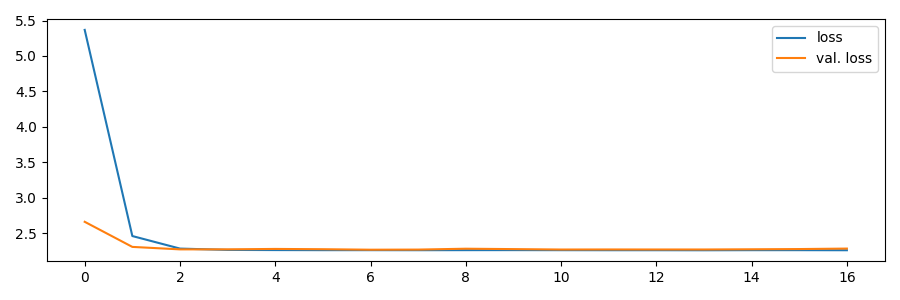

In [33]:
er.plot_training_history(history2, figsize=figsize)
tr2, vl2 = history2.history["loss"][-1], np.min(history2.history["val_loss"])
print(f'Loss: {tr2:.4f} (training, final), {vl2:.4f} (validation, best)')

## Evaluation

**We can now obtain and evaluate the predictions. On the _training set_:**

R2: 0.6055681204210561
MAE: 1.9193449121087653


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
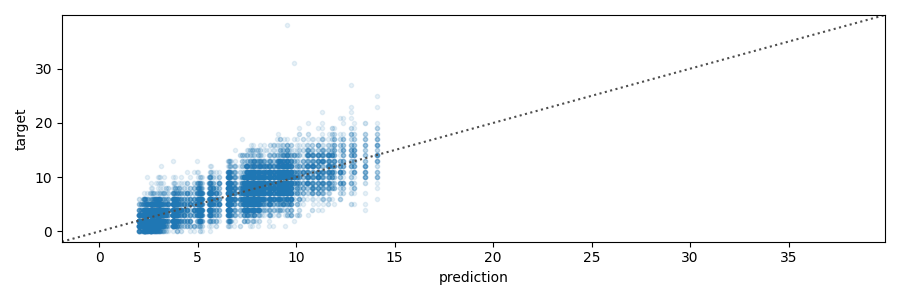

In [34]:
tr_preds2 = nn2(tr_data_in).mean()
slabel = 'total'
er.plot_pred_scatter(tr_preds2, tr_data[slabel], figsize=figsize)
print(f'R2: {metrics.r2_score(tr_data[slabel], tr_preds2)}')
print(f'MAE: {metrics.mean_absolute_error(tr_data[slabel], tr_preds2)}')

## Evaluation

**And we get similar results for the test set**

R2: 0.5998397240289319
MAE: 1.9308035677266226


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
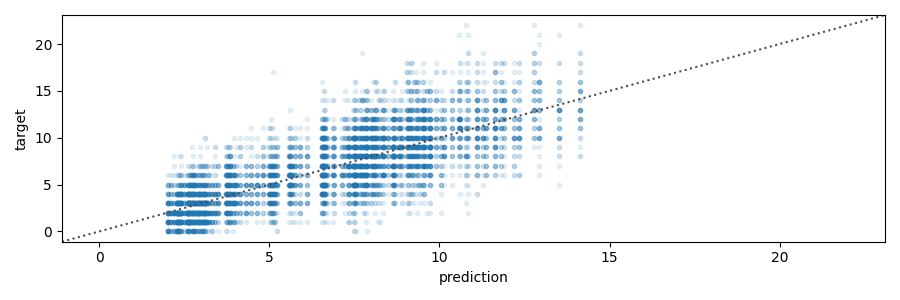

In [35]:
ts_preds2 = nn2(ts_data_in).mean()
er.plot_pred_scatter(ts_preds2, ts_data['total'], figsize=figsize)
print(f'R2: {metrics.r2_score(ts_data[slabel], ts_preds2)}')
print(f'MAE: {metrics.mean_absolute_error(ts_data[slabel], ts_preds2)}')

The results have actually improved, thanks to the additional input